In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
my_drive_path = '/content/drive/My Drive/SAM'
if not os.path.exists(my_drive_path):
    os.makedirs(my_drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install tifffile

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c4v_l9lj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c4v_l9lj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Stream the Dataset

In [ ]:
from datasets import load_dataset
stream_dataset = load_dataset("back2classroom/sidewalks", split='train', streaming=True)
# print(next(iter(stream_dataset)))

(Optional) Downlaod the dataset to local to avoid repeated streaming
- Filter out images with empty mask to save trainning time

In [ ]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import os
import io

pass_num=0
sum=0
for item in stream_dataset:
    image_data = item['tif']
    mask_data = item['label_tif']
    filename = item['filename']

    image = Image.open(io.BytesIO(image_data))
    mask = Image.open(io.BytesIO(mask_data))

    ground_truth_mask = np.array(mask)

    if np.any(ground_truth_mask != 0):
        ground_truth_mask[ground_truth_mask != 0] = 255

        image_path = os.path.join("/content/drive/MyDrive/SAM/sidewalk/image", f'{filename}.tif')
        mask_path = os.path.join("/content/drive/MyDrive/SAM/sidewalk/mask", f'{filename}.png')
        if not os.path.exists(image_path) and not os.path.exists(mask_path):
          with open(image_path, 'wb') as img_file:
              img_file.write(image_data)

          mask_image = Image.fromarray(ground_truth_mask.astype(np.uint8))
          mask_image.save(mask_path)

        sum=sum+1
    else:
      pass_num=pass_num+1

print('All non-empty data items saved.')
print(pass_num)
print(sum)

All non-empty data items saved.
91137
88863


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  # if y_indices.size == 0 or x_indices.size == 0:    ## for empty masks -->return bbox [0,0,0,0]
  #       return [0, 0, 0, 0]
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Option 1: Prepare traning dataset directly from streaming data

1.   List item
2.   List item



In [ ]:
# ## Stream Dataset

from torch.utils.data import IterableDataset
import numpy as np
from PIL import Image
import io
 from torch.utils.data import DataLoader

class SAMIterableDataset(IterableDataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def process_item(self, item):
        image_data = item['tif']
        image = Image.open(io.BytesIO(image_data))
        mask_data = item['label_tif']
        mask = Image.open(io.BytesIO(mask_data))
        ground_truth_mask = np.array(mask)
        ground_truth_mask= (ground_truth_mask / 255.).astype(np.uint8)
        ground_truth_mask[ground_truth_mask != 0] = 255

        if np.max(ground_truth_mask) == 0:  # Skip empty masks
            return None

        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

    def __iter__(self):
        for item in self.dataset:
            processed_item = self.process_item(item)
            if processed_item is not None:  # Yield only non-empty processed items
                yield processed_item

sam_dataset = SAMIterableDataset(stream_dataset, processor)
train_dataloader = DataLoader(sam_dataset, batch_size=2, drop_last=True, num_workers=2)

In [ ]:
print(len(os.listdir("/content/drive/MyDrive/SAM/sidewalk/image")))
print(len(os.listdir("/content/drive/MyDrive/SAM/sidewalk/mask")))

88862
88862


Option 2: Downnload the dataset to local and prepare the dataset

In [ ]:
from torch.utils.data import IterableDataset
import numpy as np
from PIL import Image
import io
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, image_folder, mask_folder, processor):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.processor = processor
        # Load and sort image files based on their basename, ensuring they end with '.tif'
        self.image_files = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tif')], key=lambda x: os.path.splitext(x)[0])
        self.mask_files = sorted([f for f in os.listdir(self.mask_folder) if f.endswith('.png')], key=lambda x: os.path.splitext(x)[0])

        # Print file lists to debug
        print("Image files:", self.image_files)
        print("Mask files:", self.mask_files)

        assert len(self.image_files) == len(self.mask_files), "Mismatch in the number of images and masks"

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.image_files[index])
        mask_path = os.path.join(self.mask_folder, self.mask_files[index])
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        ground_truth_mask = np.array(mask)  # Directly using the mask as it is already binary
        ground_truth_mask= (ground_truth_mask / 255.).astype(np.uint8)

        prompt = get_bounding_box(ground_truth_mask)  # Assume this function is defined elsewhere
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

    def __len__(self):
        return len(self.image_files)

# SAM Fintuning

In [ ]:
from transformers import SamProcessor
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_dataset  = SAMDataset(image_folder='/content/drive/MyDrive/SAM/sidewalk/image', mask_folder='/content/drive/MyDrive/SAM/sidewalk/mask', processor=sam_processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
## check out the dataset
for data in sam_dataset:
    for k, v in data.items():
        print(k, v.shape)
    break
print(len(sam_dataset))

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)
88862


In [ ]:
batch_size = 4
train_dataloader = DataLoader(sam_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
## checkout each batch
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


Load the model
-- better download it first

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

Optimizer and loss fucntion

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
# model = SamModel.from_pretrained("facebook/sam-vit-base")
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Define the path to the checkpoint
checkpoint_path = "/content/drive/My Drive/SAM/checkpoint.pth_1"

# Check if a checkpoint exists
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print("Starting training from scratch")

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

# Training loop
num_epochs = 3
for epoch in range(start_epoch, num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # Save the model and optimizer state along with epoch number
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }, checkpoint_path)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    with open('loss.txt', 'a') as f:
       f.write(f'EPOCH: {epoch}\n Mean loss: {mean(epoch_losses)} \n\n')

Starting training from scratch


  0%|          | 0/22216 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 22216/22216 [2:23:08<00:00,  2.59it/s]


EPOCH: 0
Mean loss: 0.43268537744892716


100%|██████████| 22216/22216 [2:23:10<00:00,  2.59it/s]


EPOCH: 1
Mean loss: 0.39350346685764487


100%|██████████| 22216/22216 [2:23:10<00:00,  2.59it/s]


EPOCH: 2
Mean loss: 0.3775089961471198


# Inference
- Input: image + prompt (bbox as prompt)

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
# Load the model configuration

model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sidewalk_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
checkpoint_path="/content/drive/MyDrive/SAM/checkpoint.pth_1"
checkpoint = torch.load(checkpoint_path)
sidewalk_model.load_state_dict(checkpoint['model_state'])
# sidewalk_model.load_state_dict(torch.load("/content/drive/MyDrive/SAM/checkpoint.pth_1"))

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sidewalk_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## 1. Infernece on a random training example

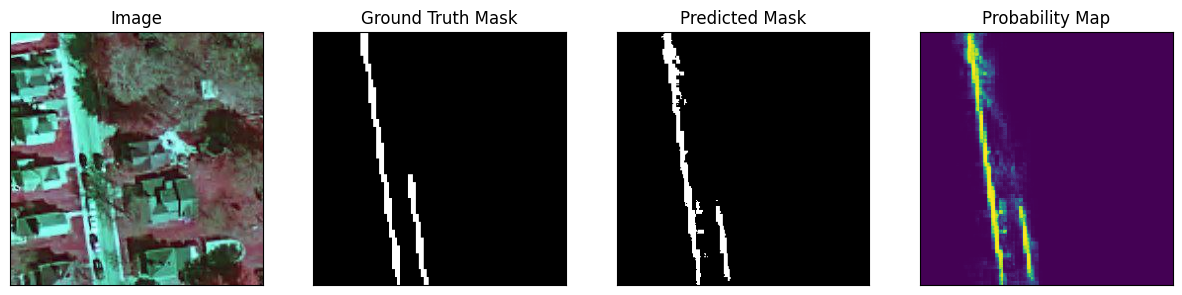

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image

# let's take a random training example
# idx = random.randint(0, 88861)

# load image
# test_image = sam_dataset[idx]["image"]
test_image_path="/content/drive/MyDrive/SAM/sidewalk/image/40_11_20.tif"
test_mask_path="/content/drive/MyDrive/SAM/sidewalk/mask/40_11_20.png"
test_image = Image.open(test_image_path)
mask = Image.open(test_mask_path)
mask = np.array(mask)  # Directly using the mask as it is already binary
ground_truth_mask= (mask / 255.).astype(np.uint8)

# get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(sam_dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)   ##bbox as prompt

# prepare image + box prompt for the model  --> prompt: list of lists
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

sidewalk_model.eval()

# forward pass
with torch.no_grad():
    outputs = sidewalk_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

axes[1].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Ground Truth Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Predicted Mask")

# Plot the second image on the right
axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

2. Apply a trained model on large image
- Break the large image into patchies then  apply it
- Put the patchies together (to do) -- unnatural boundary

- new image - without prompt - what to do
    - Input points/grid as prompt
    - prompt : a list of lists
    - allow empty prompt

In [ ]:
large_test_images = tifffile.imread("/content/4.tif")
# large_test_images = np.array(Image.open("/content/1.jpg"))
patches = patchify(large_test_images, (256, 256,3), step=256)  #Step=256 for 256 patches means no overlap
print(large_test_images.shape)

(1716, 1790, 3)


In [ ]:
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

print(np.array(input_points).shape)   ## grid as prompt
patches.shape

(1, 1, 100, 2)


(6, 6, 1, 256, 256, 3)

(256, 256, 3)


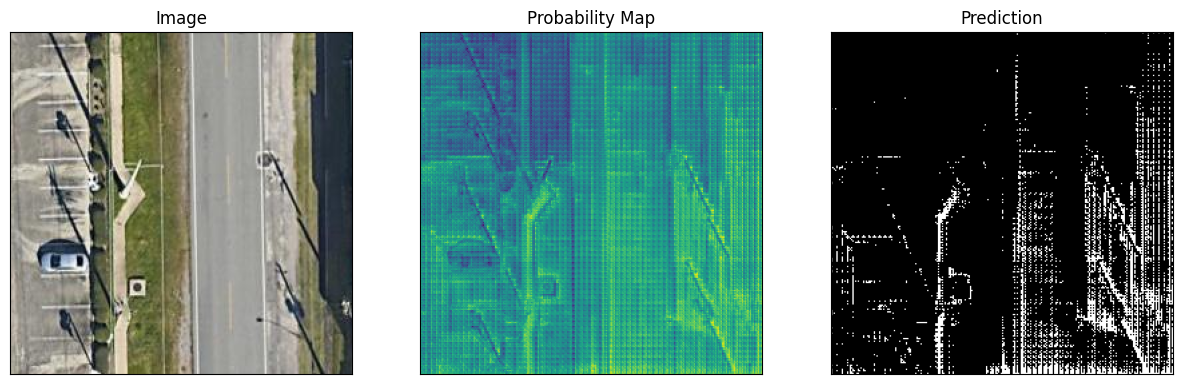

In [ ]:
#Or pick a specific patch for study.
i, j = 0,3
# i, j = 12,3
# i, j = 14,3
# Selectelected patch for segmentation
random_array =  patches[i, j, 0, :, :, :]
print(random_array.shape)

# print(patches.shape)
single_patch = Image.fromarray(random_array)

# prepare image for the model
#without providing any prompt
inputs = processor(single_patch, return_tensors="pt")

#grid as prompts
# inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
sidewalk_model.eval()


# forward pass
with torch.no_grad():
  outputs = sidewalk_model(**inputs, multimask_output=False)

# apply sigmoid  --> probility
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.45).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()